# LIME for images

In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f27716b8c87a078a3a1b375bbc8781820c8b9ddb7dedc4cb2f89a29d32fe02be
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import urllib.request

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from lime import lime_image
from skimage.segmentation import mark_boundaries
import pandas as pd
from PIL import Image
import requests
from io import BytesIO

In [3]:
url ="https://github.com/SalvatoreRa/CNNscan/blob/main/img/manja-vitolic-gKXKBY-C-Dk-unsplash.jpg?raw=true"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
model  = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 141MB/s]


In [4]:
def Image_process_lime(img, model):
  # resize and take the center part of image to what our model expects
  def get_input_transform():
      normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
      transf = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          normalize
      ])

      return transf

  def get_input_tensors(img):
      transf = get_input_transform()
      # unsqeeze converts single image to batch of 1
      return transf(img).unsqueeze(0)

  path_imgnet = 'https://raw.githubusercontent.com/SalvatoreRa/CNNscan/main/imagenet_class_index.json'
  idx2label, cls2label, cls2idx = [], {}, {}
  with urllib.request.urlopen(path_imgnet) as read_file:
      class_idx = json.load(read_file)
      idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
      cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
      cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

  img_t = get_input_tensors(img)
  model.eval()
  logits = model(img_t)
  probs = F.softmax(logits, dim=1)
  probs5 = probs.topk(5)
  probs_top5 = tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))
  df =pd.DataFrame(probs_top5, columns = ["probability", "Idx class", "class name"])
  return df


probs_top5 = Image_process_lime(img, model)
probs_top5

,probability,Idx class,class name
0,0.244941,285,Egyptian_cat
1,0.098700,281,tabby
2,0.067708,463,bucket
3,0.057305,999,toilet_tissue
4,0.052084,457,bow_tie


  0%|          | 0/1000 [00:00<?, ?it/s]

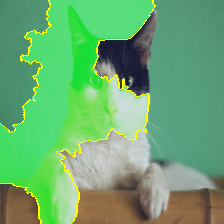

In [5]:
def lime(img, model, N_samples):
  def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

  def get_preprocess_transform():
      normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
      transf = transforms.Compose([
          transforms.ToTensor(),
          normalize
      ])

      return transf

  pill_transf = get_pil_transform()
  preprocess_transform = get_preprocess_transform()

  def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

  test_pred = batch_predict([pill_transf(img)])
  test_pred.squeeze().argmax()

  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                          batch_predict, # classification function
                                          top_labels=5,
                                          hide_color=0,
                                          num_samples= N_samples)

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
  img_boundry1 = mark_boundaries(temp/255.0, mask)
  img_boundry1 = Image.fromarray(np.uint8(img_boundry1*255))

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
  img_boundry2 = mark_boundaries(temp/255.0, mask)
  img_boundry2 = Image.fromarray(np.uint8(img_boundry2*255))

  return img_boundry1, img_boundry2


img_boundry1, img_boundry2 = lime(img, model, 1000)
img_boundry2

In [6]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)


path_imgnet = 'https://raw.githubusercontent.com/SalvatoreRa/CNNscan/main/imagenet_class_index.json'
idx2label, cls2label, cls2idx = [], {}, {}
with urllib.request.urlopen(path_imgnet) as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.24494106, 285, 'Egyptian_cat'),
 (0.09869971, 281, 'tabby'),
 (0.06770786, 463, 'bucket'),
 (0.05730476, 999, 'toilet_tissue'),
 (0.052083563, 457, 'bow_tie'))